<a href="https://colab.research.google.com/github/GuilhermeRuy97/Data-Science-em-Producao-Meigarom/blob/main/data_science_em_producao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-Store Sales Prediction


## 0.0 IMPORTS

In [4]:
!pip install inflection

In [5]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

### 0.1 Helper Functions

### 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'store.csv', low_memory = False)

#Fazendo um merge dos arquivos guardando em "store"

df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

In [7]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
376530,997,1,2014-08-04,7025,500,1,1.0,0,1.0,d,c,5840.0,7.0,2010.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


## 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [8]:
#É interessante fazer uma cópia dos dados ao mudar de sessão para resgatá-los no futuro.

df1 = df_raw.copy()

### 1.1 Rename Columns

In [9]:
#Nem sempre os dados vem com nomes adequados para o desenvolvimento dos algoritmos;
#Neste caso é mais controlado pois são dados do kaggle.

df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
#Transformando os dados de camel case para snake case

#Colunas originais

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

#Mudando coluna para snake case

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#Rename

df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [12]:
print( f'Number of Rows: { df1.shape[0] }')
print( f'Number of Columns: { df1.shape[1] }')


Number of Rows: 784451
Number of Columns: 18


### 1.3 Data Types

In [13]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                           float64
state_holiday                    object
school_holiday                  float64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
#Transformando a data de object para data

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                  float64
state_holiday                           object
school_holiday                         float64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [15]:
#Mostrando a soma de todas as linhas que tenha pelo menos 1 na

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                1
state_holiday                        1
school_holiday                       1
store_type                           0
assortment                           0
competition_distance              2015
competition_open_since_month    249450
competition_open_since_year     249450
promo2                               0
promo2_since_week               394471
promo2_since_year               394471
promo_interval                  394471
dtype: int64

### 1.5 Fillout NA

In [16]:
df1['competition_distance'].max

<bound method Series.max of 0          1270.0
1           570.0
2         14130.0
3           620.0
4         29910.0
           ...   
784446    16180.0
784447     8480.0
784448     3640.0
784449      300.0
784450     2960.0
Name: competition_distance, Length: 784451, dtype: float64>

In [17]:
# competition_distance
# Trocando o valor em NA pelo maior valor:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    
# Trocando a data de "competição desde o mes" pela data de venda da ultima compra
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year     
# Mesmo processo do mes para o ano
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

# promo2                               
# promo2_since_week               
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

# promo_interval                  
month_map = {
1: 'Jan', 
2: 'Feb', 
3: 'Mar', 
4: 'Apr', 
5: 'May', 
6: 'Jun', 
7: 'Jul', 
8: 'Ago', 
9: 'Sep', 
10: 'Oct', 
11: 'Nov', 
12: 'Dec' }

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )

In [18]:
#Repare que a soma agora de NA's é 0

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           1
state_holiday                   1
school_holiday                  1
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change Types

In [19]:
#Depois de se fazer alterações em colunas, é importante refazer a busca dos tipos
#para conferir se o tipo original não foi alterado.

In [20]:
df1.dtypes

#Repare que o competition_sincer_week é um float

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                  float64
state_holiday                           object
school_holiday                         float64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                  float64
state_holiday                           object
school_holiday                         float64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descriptive Statistical

In [23]:
#Selecionando os dados numéricos e categóricos

num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

In [24]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
69316,187,6,4397,532,1,0.0,0.0,19360.0,5,2015,0,22,2015,0
235633,369,4,0,0,0,0.0,1.0,5870.0,4,2014,0,1,2015,0


In [25]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
422837,0,d,a,0,Jun
255339,0,d,a,0,Dec


#### 1.7.1 Numerical Attributes

In [26]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, maax, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenete
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std',
            'skew', 'kurtosis'] )

In [27]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.410185,558.0,321.962419,-0.000729,-1.201040
1,day_of_week,1.0,7.0,6.0,3.994637,4.0,1.998828,0.003268,-1.247821
2,sales,0.0,41551.0,41551.0,5855.899947,5822.0,3889.244381,0.631308,1.728005
3,customers,0.0,5494.0,5494.0,638.103971,614.0,466.165161,1.598210,7.063196
4,open,0.0,1.0,1.0,0.831290,1.0,0.374496,-1.769260,1.130284
5,promo,0.0,1.0,1.0,0.381006,NaN,0.485634,0.490058,-1.759848
6,school_holiday,0.0,1.0,1.0,0.185976,NaN,0.389087,1.614159,0.605510
7,competition_distance,20.0,200000.0,199980.0,5937.302980,2330.0,12514.458762,10.221906,147.753154
8,competition_open_since_month,1.0,12.0,11.0,6.963337,7.0,3.307885,-0.114911,-1.229530
9,competition_open_since_year,1900.0,2015.0,115.0,2010.408237,2012.0,5.517748,-6.902006,117.129054


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


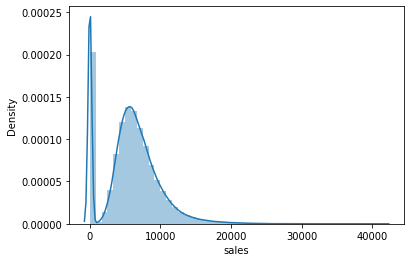

In [28]:
sns.distplot( df1['sales'])

#### 1.7.2 Categorical Attributes

In [29]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

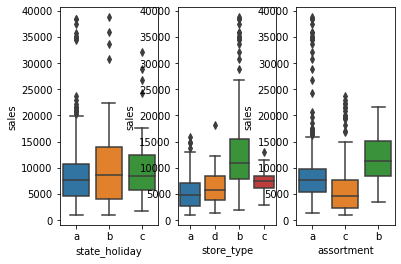

In [30]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1)
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot( 1, 3, 2)
sns.boxplot( x = 'store_type', y = 'sales', data = aux1)

plt.subplot( 1, 3, 3)
sns.boxplot( x = 'assortment', y = 'sales', data = aux1)

### 1.8

# 2.0 PASSO 02 - FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

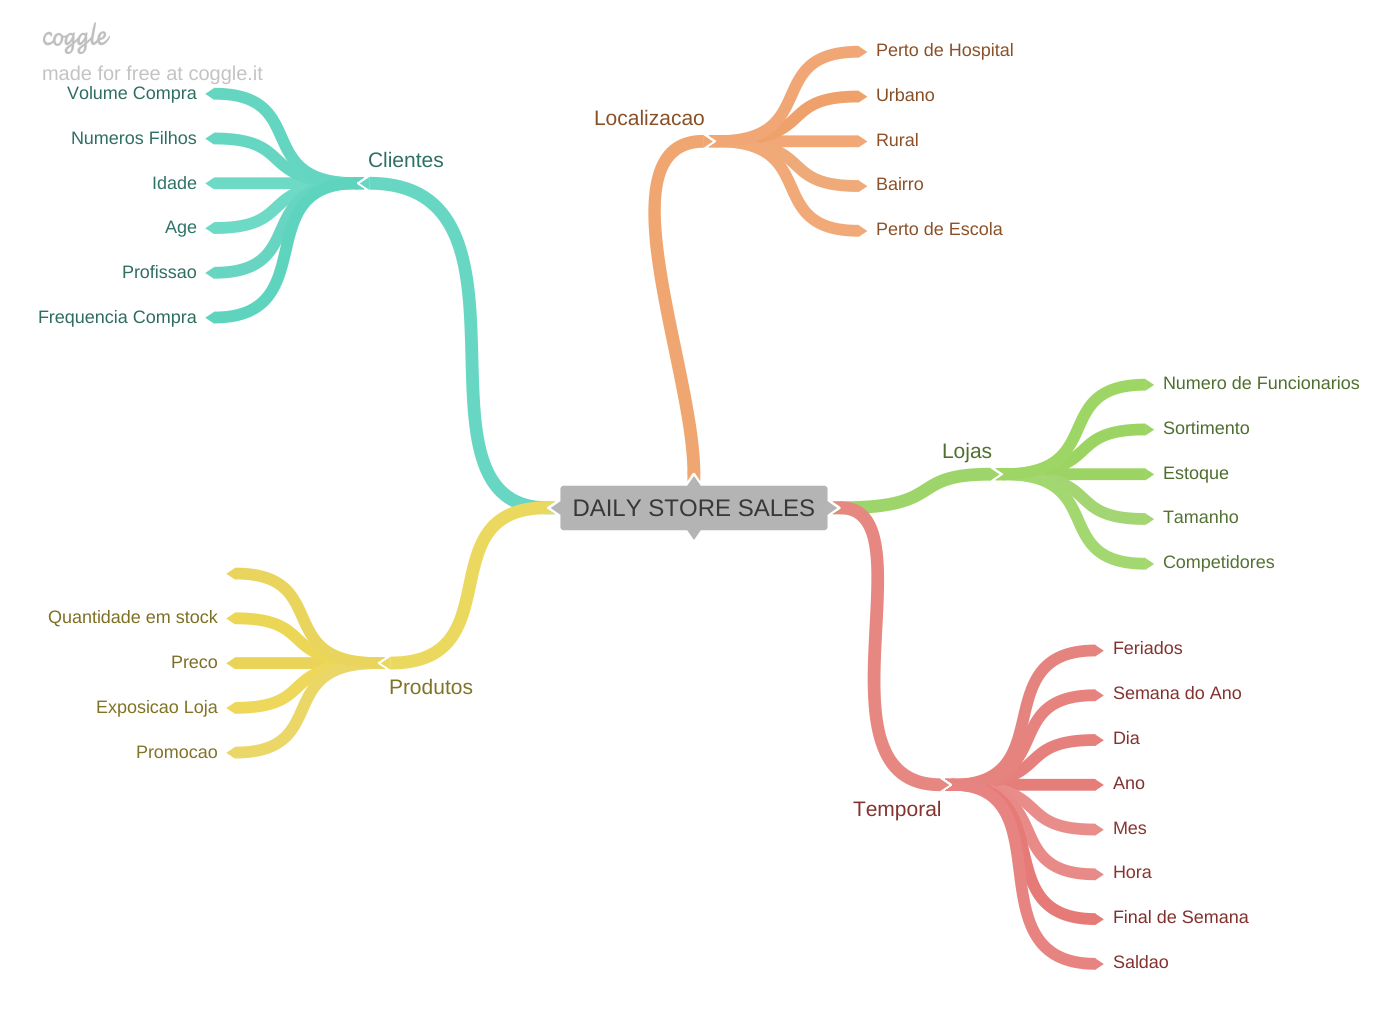

In [31]:
Image('/content/MindMapHypotesis.png')

## 2.1 Criação das Hipóteses

Este passo geralmente acontece na reunião de brainstorming, onde se trazem os times de negócio para a realização das perguntas. Por ex, perguntar quais variáveis eles acham que afetam as vendas.

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas de maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com mais competidores deveriam vender menos.

**7.** Lojas com competidores mais próximos deveriam vender menos.

**8.** Lojas com competidores à mais tempo deveriam vender mais.

etc

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas com promoções ativas por mais tempo deveriam vender mais.

etc

### 2.1.3 Hipóteses Tempo

**1.** Lojas que entram em mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**5.** Lojas deveriam vender mais ao longo dos anos.

**6.** Lojas deveriam vender mais no segundo semestre do ano.

**7.** Lojas deveriam vender menos durante os feriados escolares.

**8.** Lojas deveriam vender mais depois do dia 10 de cada mês.

etc

## 2.2 Lista Final de Hipóteses

Nesta etapa, é visto quais dados temos nos datasets (por ex, não temos o número de funcionários para trabalhar no momento) e então, selecionadas as hipóteses que trabalharemos.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender menos durante os feriados escolares.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos durante os feriados escolares.